# ARGweaver analysis

## Stage one

* Sweeps are called in each population based on pi.

* ARGweaver is run on both all male X as well as on subsets from each geographic region.

* Intersect with other stats (by both world and regions) to lend credibility:
    - ARGweaver tmrca_half and my tmrca stat.
    - My coal_half stat.
    - Proportion of singletons among SNPs.
    - sweep node count
    - connected short branches count

* Compute jc diststances between individuals in 1Mb windows or each 1Mb window and NJ trees for each 1Mb window and 


## Stage two

* For each sampled tree we compute sweep stat scores:
    - Find the highest scoring sweep and record its score, height and time. 
    - Also record for each tree the high-scoring sweep nodes above some cutoff and record sweep score, sweep time and the set of clade leaves. That turns into a vector with zeroes and ones for each individual designating if they are in a sweep or not. That way I can build a matrix of site by indivuals later.
    - For each 100kb window, store a matrix (len = number individuals) with counts of how many other individuals fall in the same sweep clade as an individual.

* To measure if an individual is part of the same sweep in consequtive 100kb windows I can do a jaccard measure type stat: 

        sum(min(x, y) for x, y in zip(left_window, right_window)) / (sum(left_window) + sum(right_window))

  where left_window and right_window are the i'th row (corresponding to an individual) in the matrices for two adjacent windows. I should do the state both left and right of the current window to get a rolling average. This should give a measure revealing the extent of each sweep along the chromosome.

* To identify separate sweeps affecting one 100kb window, I can do graph pruning:
    - I can make a graph with edge widths proportional to the number of times each pair of individuals is seen in the same high-scoring sweep clade. For this I use the rows of the matrix for a single 100kb window.
    - Then do graph pruning, removing the thinest branches until I have strongly connected components with smilar edge widths (entropy of at least 1).


I should end up with the following stats for each 100kb window:

* mean and median score of highest scoring sweep node
* mean and median height of highest scoring sweep node
* mean and median time of highest scoring sweep node

I should end up with the following stats for population for each 100kb window:

* consequtiveness stat (summarized accross individuals in a population)
* sweep label showing wihch sweep the 100kb window (if more than one) this population is part of.
    



Maybe someting along the lines of tmrca_half/tmrca stratified by populations. You can compute it for each population and then plot it as colors in a pop by chrom window matrix.
Entropy of coalescence counts.

Try do do someting along the chromosome too:
Maybe extract the leaves that are part of a sweep and see if it is the same set for neighboring trees

In addition to the statistics computed for each sampled by `arg-summaryze`, I compute a number of tree statistics my self. These are:

* **TMRCA** (my_tmrca): time to TMRCA of tree.
* **TMRCA halftime** (my_tmrca_half): time until at a clade consist of at least 50% of sample.
* **Coalescence half time** (coal_half): time until at least half the sample is part of any subtree (have coalesced). Same as TMRCA_half but not requireing that they are in a single subtree.
* **Sweep node count** (SwNC): Number of nodes with a short dist up and at least one sort dist down. Top node with no parent is not included.
* **Short branch enrichment** (ShBE): Count how many of the shortest branches sort brances that together make up no more than e.g. 10% of total tree length.
* **Largest short branch tree** (LShBT): Find the largest set of connected branches that are all smaller or equal to some maximum length.

## Preliminaries

### Set up parallel computing

In [1]:
import ipyparallel
from ipyparallel import depend, require

# create client & view
rc = ipyparallel.Client()
dview = rc[:]
bview = rc.load_balanced_view() # you can set block=True to have this apply globally

# scatter 'id', so id=0,1,2 on engines 0,1,2
dview.scatter('node_id', rc.ids, flatten=True)
print("Engine IDs: ", dview['node_id'])
# create a Reference to `id`. This will be a different value on each engine
ref = ipyparallel.Reference('node_id')

Engine IDs:  [0, 1, 2]


### Libraries

In [2]:
with dview.sync_imports(): # imports libs across dview
    import re, os, sys, math, collections, subprocess, resource, bisect, random
    from pathlib import Path
    import scipy
    import numpy
    import pandas
    from pandas import DataFrame
    from ete3 import Tree

from ete3 import Tree, NodeStyle, TreeStyle, TextFace
from scipy.stats import entropy
    
# dview.execute('import resource, subprocess, collections, math, re')
# dview.execute('import pandas as pd')
# dview.execute('import numpy as np')
# dview.execute('from ete3 import Tree')

importing re on engine(s)
importing os on engine(s)
importing sys on engine(s)
importing math on engine(s)
importing collections on engine(s)
importing subprocess on engine(s)
importing resource on engine(s)
importing bisect on engine(s)
importing random on engine(s)
importing Path from pathlib on engine(s)
importing scipy on engine(s)
importing numpy on engine(s)
importing pandas on engine(s)
importing DataFrame from pandas on engine(s)
importing Tree from ete3 on engine(s)


### Hide deprecation warnings

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning) 

### Paths to analysis dirs

In [4]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')

scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

steps_dir = root_dir / 'steps'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
sample_dir = root_dir / 'steps/argweaver/output'
tmrca_dir = root_dir / 'steps/argweaver/tmrca'
stats_dir  = root_dir / 'steps/argweaver/stats'

### Convenience functions

In [5]:

def scatter_func(f):
    dview.scatter(f.__name__, [f]*len(bview), flatten=True)    


def getmem():
    p = subprocess.Popen("echo $HOSTNAME", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = p.communicate()
    return node_id, stdout.decode().strip(), resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024

def print_mem():
    for node_id, host_name, mem in  dview.apply(getmem).get():
        print("{}{: >10}{: 10.2f} Mb". format(node_id, host_name, mem))

print_mem()


# # list comprehension in parallel:
# dv.scatter('xs', range(24))
# %px y = [x**2 for x in xs]
# np.array(dv.gather('y'))

0    s04n51    109.10 Mb
1    s04n51    109.12 Mb
2    s04n51    109.11 Mb


### Plotting

In [6]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import mpld3

#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

### Simple timer util

In [7]:
import time
class Timer:    
    def __enter__(self):
        self.start = time.clock()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start
        print("{:.0f} min {:.1f} sec".format(self.interval//60, self.interval % 60))
   

## Mean TMRCA statistics

Decorator for easy use of the hdf stores as if they were data frames:

In [8]:
from functools import wraps

def dfstore(groupby=[]):
    def decorator(func):
        @wraps(func)
        def func_wrapper(df):
            df = pandas.read_hdf(str(df))        
            if groupby:
                result_df = df.groupby(groupby).apply(func)
                result_df.index = result_df.index.droplevel(level=len(groupby))
            else:
                result_df = func(df)
            return result_df
        return func_wrapper
    return decorator

Build dataframe with mean tmrca and tmrca_half for each 100kb analysis and write it to a HDF store:

Path for storing window stats

In [9]:
store_path = results_dir / 'tmrca_window_stats.store'

In [10]:
#@window(size=10000)
@dfstore(groupby=['chain'])
def tmrca_means(df): 
    return DataFrame({'start': df.start.min(),
                      'end': df.end.max(),
                      'tmrca_half': [df.tmrca_half.mean()], 
                      'tmrca': [df.tmrca.mean()] })                 

# #@window(size=10000)
# @dfstore(groupby=['chain'])
# def tmrca_means(df):    
#     return DataFrame({'chain': ident_scalar(df.chain),
#                       'MCMC_sample': ident_scalar(df.MCMC_sample),
#                       'start': df.start.min(),
#                       'end': df.end.max(),
#                       'tmrca_half': [df.tmrca_half.mean()], 
#                       'tmrca': [df.tmrca.mean()],                     
#                       'my_tmrca': [df.my_tmrca.mean()],
#                       'my_tmrca_half': [df.my_tmrca_half.mean()],
#                       'coal_half': [df.coal_half.mean()],
#                       'shbe': [df.shbe.mean()],
#                       'lshbt': [df.lshbt.mean()],
#                       'swnc': [df.swnc.mean()],
#                       'sgm_len': [df.sgm_len.mean()]})

scatter_func(tmrca_means)
tmrca_files = sorted((tmrca_dir / 'World').iterdir())
stats_df = pandas.concat(dview.map(tmrca_means, tmrca_files))
stats_df.to_hdf(str(store_path), 'df', mode='w')

Read HDF store back in

In [11]:
stats_df = pandas.read_hdf(store_path, 'df')
stats_df.head()

,end,start,tmrca,tmrca_half
chain,,,,
1,100000,0,45938.991111,13253.034466
2,100000,0,44555.047410,12125.234949
1,200000,100000,46976.548344,13388.742301
2,200000,100000,48466.731852,14866.522936
1,300000,200000,52201.888319,18006.690110


Plot the stats for both chains pooled:

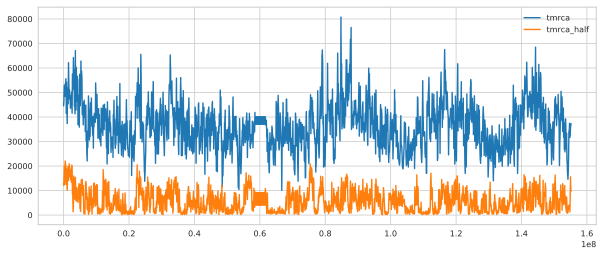

In [12]:
df = stats_df.reset_index()
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df.start, df.tmrca)
ax.plot(df.start, df.tmrca_half)
ax.legend(loc='upper right')
plt.show()

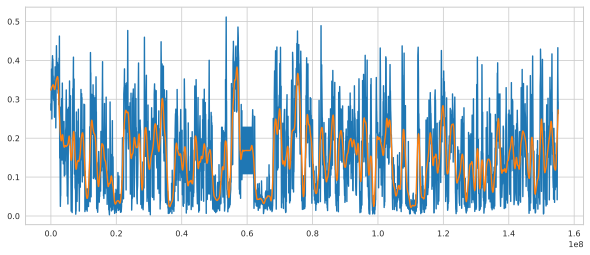

In [13]:
df = stats_df.reset_index()
fig, ax = plt.subplots(figsize=(10, 4))
ratio = df.tmrca_half/df.tmrca
ax.plot(df.start, ratio)

filtered = lowess(ratio, df.start, is_sorted=True, frac=0.01, it=0)
ax.plot(filtered[:,0], filtered[:,1])

plt.show()


Plot the $-\log\Big[\frac{TMRCA_{half}}{TMRCA}\Big]$

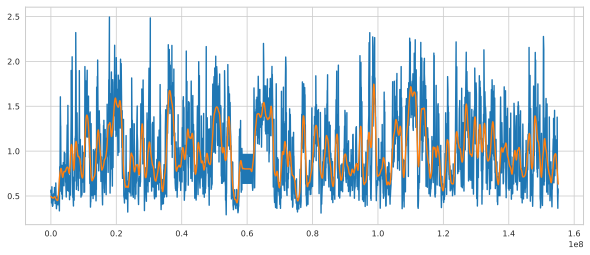

In [14]:
df = stats_df.reset_index()
fig, ax = plt.subplots(figsize=(10, 4))
log_ratio = -numpy.log10(df.tmrca_half/df.tmrca)
ax.plot(df.start, log_ratio)

filtered = lowess(log_ratio, df.start, is_sorted=True, frac=0.01, it=0)
ax.plot(filtered[:,0], filtered[:,1])

plt.show()


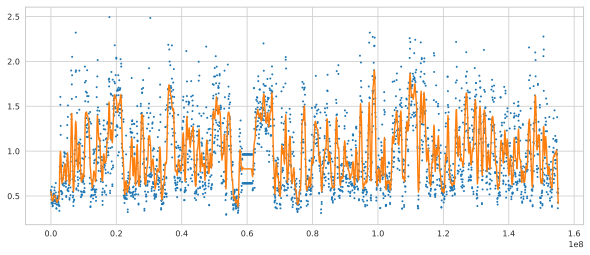

In [15]:

df = stats_df.reset_index()
fig, ax = plt.subplots(figsize=(10, 4))
log_ratio = -numpy.log10(df.tmrca_half/df.tmrca)
ax.plot(df.start, log_ratio, 'o', ms=2)

filtered = lowess(log_ratio, df.start, is_sorted=True, frac=0.005, it=0)
ax.plot(filtered[:,0], filtered[:,1])

plt.show()


In [16]:
# df = stats_df.reset_index()
# fig, ax = plt.subplots(figsize=(10, 4))
# ax.plot(df.start, df.coal_half, label='Coalescence half time') 
# ax.legend(loc='upper right')
# plt.show()

In [17]:
# df = stats_df.reset_index()
# fig, ax = plt.subplots(figsize=(13, 4))
# ax.plot(df.start, df.lshbt, label='Largest short branch tree')
# ax.legend(loc='upper right')
# #plt.show()
# mpld3.display(fig)

In [18]:
# df = stats_df.reset_index()
# fig, ax = plt.subplots(figsize=(10, 4))
# ax.plot(df.start, df.shbe, label='Short branch enrichment')
# ax.legend(loc='upper right')
# plt.show()

In [19]:
# df = stats_df.reset_index()
# fig, ax = plt.subplots(figsize=(10, 4))
# ax.plot(df.start, df.swnc, label='Sweep node count')
# ax.legend(loc='upper right')
# plt.show()

## Analyze convergence of mean statistics from samples in the two chains

Plot the tmrca and tmrca_half for each chain:

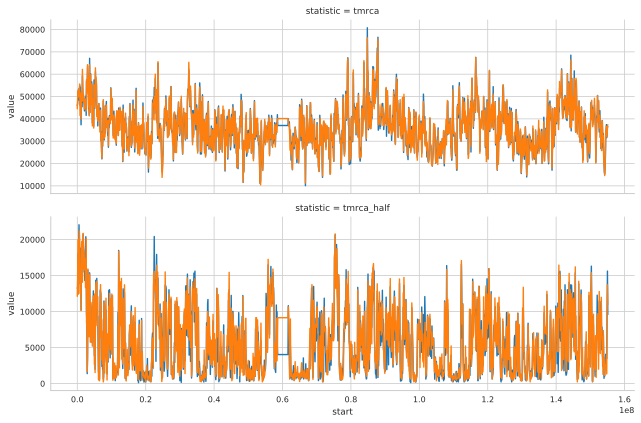

In [20]:
df = stats_df.reset_index()

plot_df = pandas.melt(df, 
                  id_vars=['start', 'chain'], 
                  value_vars=['tmrca', 'tmrca_half'], 
                  var_name='statistic', value_name='value')
g = sns.FacetGrid(plot_df, row='statistic', hue='chain', size=3, aspect=3, sharey=False)

fig = g.map(plt.plot, 'start', "value")

# fig = g.map(plt.plot, 'start', "value").fig
# mpld3.display(fig)
    


Compile a data frame with stats by sample, chain and start:

In [21]:
@dfstore(groupby=['MCMC_sample', 'chain'])
def tmrca_means_by_sample(df):    
    return DataFrame({'start': df.start.min(),
                      'end': df.end.max(),
                      'tmrca_half': [df.tmrca_half.mean()], 
                      'tmrca': [df.tmrca.mean()]})


scatter_func(tmrca_means_by_sample)
stats_by_sample_df = pandas.concat(dview.map(tmrca_means_by_sample, tmrca_files))

See if the correlation between arg stats in the two chains improve the longer they have run:

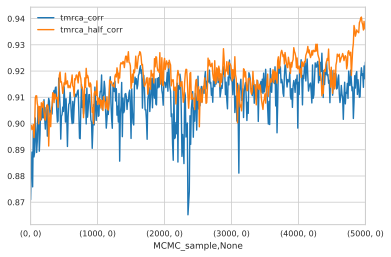

In [22]:
stats_list = ['tmrca', 'tmrca_half']

def cross_chain_corr(df):
    result_df = DataFrame()
    for stat in stats_list:
        chain0 = df.loc[df.chain == 1, ['start', stat]]
        chain1 = df.loc[df.chain == 2, ['start', stat]]
        both = pandas.merge(chain0, chain1, on='start', how='inner', 
                            suffixes=['_chain0', '_chain1'])
        result_df[stat + '_corr'] = [both[stat + '_chain0'].corr(both[stat + '_chain1'])]
    return result_df
        
g = (stats_by_sample_df
     .reset_index()
     .groupby('MCMC_sample')
     .apply(cross_chain_corr)
     .plot()
    )


# Sweep statistic

## Discretization

**Without discretization:** *each* new score computed for a given clade root will take both growing clade size *and* growing time span into account. This emans that the best node score is deternined as soon as the score stops growing as lineages are added to the clade.

**With discretization:** the scores computed for coalescences at a level only increases becuase the same discrete time span each used for computing every score while the number of included lineages only increase. That means that computed score will always include all coalescences at the discrete level of the start node. In other words: the best score for node *always* include *all* lineages coalescing at the same discretized leves as the clade root.



In [24]:

# d = [0.000000,49.193481,122.586947,232.085215,
#         395.449492,639.178343,1002.805899,1545.314509,
#         2354.701987,3562.255340,5363.846221,8051.702368,
#         12061.808515,18044.625462,26970.598323,40287.567936,
#         60155.618452,89797.454603,134021.141756,200000.000000]

# # a = [0] + list((numpy.diff(d) / 2)) + [numpy.inf]

# # print(list(zip(a[:-1], a[1:])))

# def compute_time_ranges(d):
#     """Compute the time ranges that the discrete time represents"""
#     #a = numpy.diff(d) / 2
#     a = numpy.array([0] + list((numpy.diff(d) / 2)) + [numpy.inf])
#     b = a.cumsum()
# #     b[2:] = b[2:] - b[:-2]
#     b =list(zip(b[:-1], b[1:]))
#     return b

# b = compute_time_ranges(d)
# print(list(zip(d, b)))
# #math.exp((math.log(122)) - math.exp(math.log(49)) / 2)


## Proporties of the sweep statistic

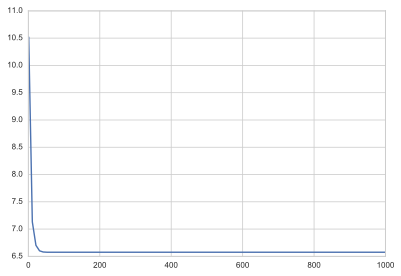

In [25]:
from tree_statistics import sweep_stat, sweep_score, \
   collect_components, component_stats, round_to_closest
import tree_statistics
import imp
#imp.reload(tree_statistics) ;

s = 100
t = numpy.linspace(1, 1000, s)
N = numpy.repeat(10000, s)
n = numpy.repeat(100, s)
i = numpy.repeat(5, s)
l = n - i + 1
#i = numpy.arange(2, 81)
g = plt.plot(t, [sweep_stat(*args) for args in zip(l, i, n, t, N)])

## Testing collection of components

In [26]:
# graph = np.array([
#     [ 0, 12,  2,  3,  4],
#     [12,  0,  9,  5,  3],
#     [ 2,  9,  0, 15, 10],
#     [ 3,  5, 15,  0, 10],
#     [ 4,  3, 10, 10,  0],
#     ])

graph = numpy.array([
[ 0, 2, 2, 1, 1],
[ 2, 0, 2, 1, 1],
[ 2, 2, 0, 2, 2],
[ 1, 1, 2, 0, 2],
[ 1, 1, 2, 2, 0],
])

threshold = 2
components = collect_components(graph, threshold = threshold)
for component in components:
    if len(component) > 1:
        print(component)
        print(component_stats(component, graph, threshold=threshold))

[0, 1, 2, 3, 4]
(0.6, 2, 2, 2.0)


## Simulations of coalescent trees

((1:10000,(3:10000,4:10000):0):0,2:10000);


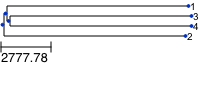

In [27]:
def standard_coalescent(nr_lineages):
    k = nr_lineages
    while k > 1:
        rate = k * (k-1) / 2
        yield -math.log(1.0 - random.random()) / rate
        k = k - 1
    
def exponential_growth(nr_lineages, beta=10):
    v = 0
    for t_star in standard_coalescent(nr_lineages):
        t = (1 / beta) * math.log(1 + beta * t_star * math.exp(-beta*v))
        yield t
        v += t
    
def sim_tree(n, N, f, discretization=[]):

    level_height = 0 # only for use with discretization
    
    lineages = list(map(str, range(1, n+1)))
    br_heights = [0 for x in lineages]
    for t in f(n):
        t *= 2 * N # scale time

        if discretization:
            next_level = round_to_closest(t+level_height, discretization)
            t = next_level - level_height
            level_height = next_level
            
        br_heights = [h+t for h in br_heights]
        j = random.randint(0, len(lineages)-1)
        lin = lineages.pop(j)
        br_height = br_heights.pop(j)
        i = random.randint(0, len(lineages)-1)
        lineages[i] = "({}:{}, {}:{})".format(lineages[i], br_heights[i], lin, br_height)
        br_heights[i] = 0

    return Tree(lineages[0] + ';')


t = sim_tree(4, 20000, standard_coalescent, discretization=[100, 1000, 10000])
print(t.write(format=1))
#t = sim_tree(15, 20000, lambda n: exponential_growth(n, beta=10))
t.render("%%inline")

# NB: leaves should always be zero...

In [28]:
t = Tree("((A:2, W:2)Q:4,(B:3,(E:1,D:1)X:2)Y:3)Z;", format=1)

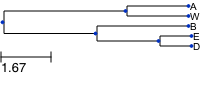

In [29]:
#print(t.get_ascii(show_internal=True))
t.render("%%inline")

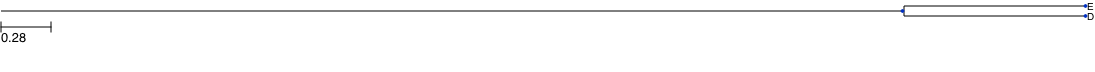

In [30]:
t2 = t.copy()
t2.prune(['E', 'D'], preserve_branch_length=True)
t2.render("%%inline")

In [32]:
imp.reload(tree_statistics)
print(tree_statistics.rel_cross_clade_tmrca(t, ['E', 'D']))
print(tree_statistics.rel_cross_clade_tmrca(t, ['E', 'D'], cross_to=['D']))


(0.5, ['B'])
(1, [])


In [33]:
import tree_statistics

import importlib
importlib.reload(tree_statistics)

with Timer():

    nr_individuals = 15
    nr_samples = 1000
    window_size = 10
    n_trees = 3

    pop_size = 10000
    max_prop = 1.0
    min_post_prob = 0.2
    graph = numpy.zeros(shape=(window_size, nr_individuals, nr_individuals))

    all_scores = list()

    # standard coalescent:
    time_fun = standard_coalescent
    # exponential growth:
    # time_fun = lambda n : tree_statistics.exponential_growth(n, beta=10)
        
#     discretization = [0.000000,49.193481,122.586947,232.085215,
#         395.449492,639.178343,1002.805899,1545.314509,
#         2354.701987,3562.255340,5363.846221,8051.702368,
#         12061.808515,18044.625462,26970.598323,40287.567936,
#         60155.618452,89797.454603,134021.141756,200000.000000]
#     discretization = list(numpy.linspace(0, 200000, num=1000, endpoint=True))
#     discretization = [0] + list(numpy.logspace(0.001, 6, num=1000000))    
    discretization = None
    
    #### This part simulates reading trees sampled from argweaver: ##########
    for i in range(nr_samples):

        # start end coordinates for ech tree
        idx = sorted(numpy.random.choice(range(1, window_size-1), size=n_trees, replace=False))
        starts = [0] + idx
        ends = starts[1:] + [window_size]

#         tree_samples = dview.map_sync(sim_tree, 
#                                       [nr_individuals] * n_trees, 
#                                       [pop_size] * n_trees, 
#                                       [time_fun] * n_trees,
#                                       [discretization] * n_trees
#                                      )
        tree_samples = [sim_tree(nr_individuals, pop_size, time_fun, discretization) \
                        for j in range(n_trees)]

        
        for start, end, tree in zip(starts, ends, tree_samples):
    #########################################################################
    
    
            scores, times, leaf_sets = tree_statistics.sweep_score(tree, 
                                                pop_size=pop_size, min_score=1,
                                                discrete_time_intervals=discretization)
        
            assert all(x > 0 for x in scores), scores
            #all_scores.extend(-numpy.log10(scores))
            all_scores.extend(scores)

## UPDATE THIS PART TO REVFLECT CODE IN TREE_STATISTIS.PY. MAYBE JUST CALL 
#             if leaf_sets:
#                 for leaf_set in leaf_sets:
#                     leaf_idx = [int(x)-1 for x in leaf_set]
#                     for i in range(start, end):
#                         for j in leaf_idx:
#                             for k in leaf_idx:
#                                 graph[i][j][k] +=1
#     #print(graph)
#     for i in range(window_size):
#         components = tree_statistics.collect_components(graph[i], threshold=min_post_prob*nr_samples)
#         components = [x for x in components if len(x) > 1]

0 min 25.0 sec


4.65583348549
0.0005964214711729623


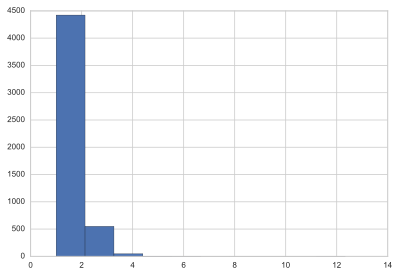

In [34]:
import bisect

print(numpy.percentile(all_scores, 99.9))
null_distr = sorted(all_scores)
test_stat = 5
p_value = (len(null_distr) - bisect.bisect_left(null_distr, abs(test_stat))) / float(len(null_distr))
print(p_value)
ax = plt.hist(all_scores)

In [35]:
        
# TODO: how to decide on a max_prob cutoff, and how to associate times with components from the graph 
# (maybe associate each edge in the matrix with a mean time)

Entropy of edge weights: 2.18623287722


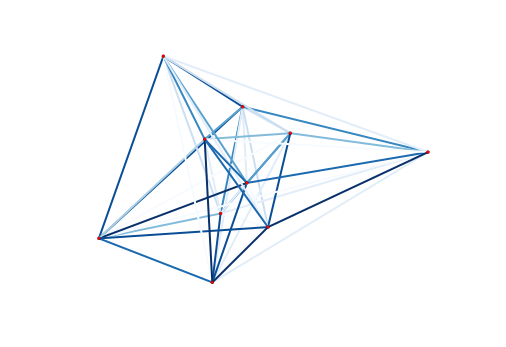

In [36]:
import networkx
graph=networkx.Graph()
for i in range(1, 11):
    for j in range(i+1, 11):
        graph.add_edge(i,j,weight=random.randint(1,10)) # specify edge data

def edge_weight_entropy(graph):
    start, end, weights = zip(*graph.edges(data='weight'))
    unique, counts = numpy.unique(weights, return_counts=True)
    return entropy(counts / counts.sum())

print('Entropy of edge weights:', edge_weight_entropy(graph))

def plot_graph(graph):
    pos=networkx.spring_layout(graph)
    colors=list(zip(*graph.edges(data='weight')))[2]
    networkx.draw(graph,pos,
            node_size=10,
#            node_color='#A0CBE2',
            edge_color=colors,
            width=2,
            edge_cmap=plt.cm.Blues,
            with_labels=False)
    plt.savefig("edge_colormap.png") # save as png
    plt.show() # display

plot_graph(graph)

45
Entropy of edge weights: 2.18837224047


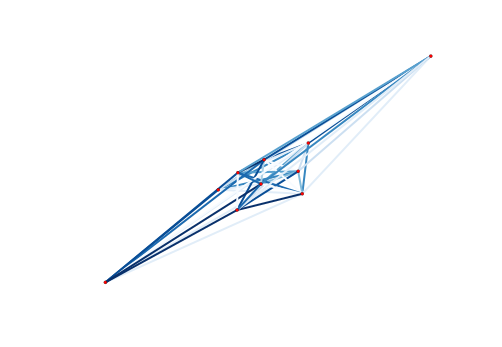

In [37]:
edges = graph.edges(data='weight')
print(len(edges))
from operator import itemgetter
a, b, weight = min(edges, key=itemgetter(2))
graph.remove_edge(a, b)
print('Entropy of edge weights:', edge_weight_entropy(graph))

plot_graph(graph)

In [38]:
# abort all running parallel tasks
#rc.abort()
# list currently running parallel tasks
#rc.outstanding

## Read sweep stats

In [ ]:
df = pandas.read_hdf(str(root_dir / 'stats2.hdf'))

## Read sweep components

In [ ]:
df = pandas.read_hdf(str(root_dir / 'comp2.hdf'))

## Read sweep component statististics

In [ ]:
df = pandas.read_hdf(str(root_dir / 'compstats2.hdf'))

## Read sweep African sister clades

In [ ]:
df = pandas.read_hdf(str(root_dir / 'sweepsister2.hdf'))

## Read non-sweep African sister clades

In [ ]:
df = pandas.read_hdf(str(root_dir / 'nonsweepsister2.hdf'))

## Plot occurences of African individuals in sister clades

In [ ]:
#
# BaseMap example by geophysique.be
# tutorial 0

"""
Using :
-- An example makes custom 'pie charts' as the markers for a scatter plot
-- Thanks to Manuel Metz for the example
"""
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
 
colors = ['red','blue','green','yellow','magenta','purple']
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']

def draw_pie(ax,ratios=[0.4,0.3,0.3], X=0, Y=0, size = 1000):
    N = len(ratios)
 
    xy = []
 
    start = 0.
    for ratio in ratios:
        x = [0] + np.cos(np.linspace(2*math.pi*start,2*math.pi*(start+ratio), 30)).tolist()
        y = [0] + np.sin(np.linspace(2*math.pi*start,2*math.pi*(start+ratio), 30)).tolist()
        xy1 = list(zip(x,y))
        xy.append(xy1)
        start += ratio

    for i, xyi in enumerate(xy):
        ax.scatter([X],[Y] , marker=(xyi,0), s=size, facecolor=colors[i], linewidth=0 )
        
fig = plt.figure(figsize=(11.7,8.3))
#Custom adjust of the subplots
plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.15,hspace=0.05)
ax = plt.subplot(111)
#Let's create a basemap around Belgium
m = Basemap(resolution='i',projection='merc', llcrnrlat=49.0,urcrnrlat=52.0,llcrnrlon=1.,urcrnrlon=8.0,lat_ts=51.0)
m.drawcountries(linewidth=0.5)
m.drawcoastlines(linewidth=0.5)
 
# m.drawparallels(np.arange(49.,53.,1.),labels=[1,0,0,0],color='black',dashes=[1,0],labelstyle='+/-',linewidth=0.2) # draw parallels
# m.drawmeridians(np.arange(1.,9.,1.),labels=[0,0,0,1],color='black',dashes=[1,0],labelstyle='+/-',linewidth=0.2) # draw meridians
 
X,Y = m(4.5,50.5)
draw_pie(ax,[0.3,0.7], X, Y,size=1000)
 
X,Y = m(5.5,50.8)
draw_pie(ax,[0.3,0.3,0.4], X,Y, size=250)
 
plt.show()

# Testing other tree statistics

In [13]:
#print("short count", get_connected_short_branches(t, 3))
print(tree_statistics.find_max_connected_short_branches(t, 4))
print(tree_statistics.tmrca_stats(t))
print(tree_statistics.count_sweep_nodes(t, max_branch_len=2))
print(tree_statistics.count_shortest_branches_within_tree_fraction(t, tree_fraction=0.1))
print(tree_statistics.rel_clade_tmrca(t, ['E', 'D']))
print(tree_statistics.rel_cross_clade_tmrca(t, ['E', 'D']))

8
(6.0, 3.0, 2.0)
1
2
0.166666666667
0.5
